In [1]:
# LIB UPLOAD CELL:
###########################################

import MAIN_MODULE as mm
import sys
path_main = '/Users/stepanvinckevich/Desktop/IMPORTANT NOW/QIS QRL/CODE/qRC/'
path_EVAL = path_main + 'EVALUATION/BRIDGEON_STM_60/'
path_PRODUCT =  path_EVAL + 'PRODUCTION/'
sys.path.append(path_main)

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.font_manager as font_manager 
from matplotlib.pyplot import gca
from matplotlib.colors import BoundaryNorm
from qutip.qip.operations import hadamard_transform
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

from time import time
from tqdm import tqdm

In [2]:
# OLD SETUP EVALUATION (AVARAGE STM 60):
b = 0.23
c = 0.91

UA = mm.hadamard_transform(1)
UB =  mm.hadamard_transform(1)

args = (UA, UB)


ent_meas_operator_list = mm.two_par_measurement_anzats(b,c, False)
sep_meas_operator_list = mm.two_par_measurement_anzats(b,c, True, *args)

# EVALUATION CELL:
###########################################
num_signal_samples = 1
#num_states_samples = 1
multiplexing = 10
# SPECIFYING MEASUREMENT ANZATS:

# FUNCTION EVALUATE IMPLEMENT ANALYSIS WITH  BRIDGE SET TO ON !!!
def evaluate_bridge(init_state, signal, depolarization_prob, operator_list):
    # Initialization
    inp = signal[2000:2200]
    result = mm.np.zeros((len(inp), multiplexing, mm.n_qubitsB))
    state = init_state
    # PRECPROCESSING --> IT IS NECESSARY TO SATISFY ECHO STATE PROPERTY. 2000 temporal preproc. steps.
    for i in range(2000):
        state = mm.encoding_step(state, signal[i])
        state = mm.evolution_step(state)
        state = mm.entangled_channel_step_old(state, depolarization_prob, operator_list) # NONSELECTIVE MEAS CHANNEL
        
    for n in range(len(inp)): # READOUT  - >  TEMPORAL MULTIPLEXING 
        state = mm.encoding_step(state, inp[n])
        for m in range(multiplexing):
            state = mm.evolution_step(state)
            state = mm.entangled_channel_step_old(state, depolarization_prob, operator_list)

            for site in range(mm.n_qubitsB):
                state, outcome = mm.separated_measurement_step(state, site + mm.n_qubitsA)
                result[n, m, site] = outcome

    return result


In [ ]:
#mm.np.random.seed(23450)
#setup_list = [13,24,25,33,34] 
setup = 34
t1 = time()
# EXECUTION CELL:
###########################################
init_state = mm.qt.tensor(*[mm.qt.rand_ket(2) for _ in range(mm.n_qubits_total)])
init_state = init_state * init_state.dag()
init_state = init_state.full()

for s in range(num_signal_samples):
    print('Signal sample num:' +  str(s))
    signal = [mm.np.random.choice(2) for _ in range(2200)]
    #signal = mm.np.load(path_main + '/data/complex_signal_9_9.npy')
    results = evaluate_bridge(init_state, signal, 0, ent_meas_operator_list ) # ENTANGLED BASIS
    results_SEP = evaluate_bridge(init_state, signal, 0, sep_meas_operator_list) # SEPARABLE BASIS
    mm.np.save(path_EVAL + str(s) + 'res_OLD_ENT' + str(0) + str(setup), results)
    mm.np.save(path_EVAL + str(s) + 'res_OLD_SEP' + str(0), results_SEP)
    mm.np.save(path_EVAL + str(s)+'signal', signal)  
t2 = time ()

print('EVALUATION TIME IS {}'.format(t2 - t1))
print('CURRENT SETUP IS {}'. format(setup))

In [ ]:
# counter = 0
# for s in range(num_signal_samples):
#     res = []
#     for i  in range(num_states_samples):
#         res.append(mm.np.load(path_EVAL + str(s) + 'results' + str(i) + '.npy'))
#     res_arr = mm.np.asarray(res)
#     res_av = mm.np.mean(res_arr, axis = 0)

#     k = mm.np.random.choice(num_states_samples)
#     if mm.np.linalg.norm(res_av.reshape(-1, mm.n_qubitsB)[:, 0] - res[k].reshape(-1, mm.n_qubitsB)[:, 0]) >= 10**-6:
#         counter += 1
# if counter == 0:
#     print ('ECHO STATE PROPERTY IS ELIGABLE')
# else:
#     print ('ECHO STATE PROPERTY FAILED')

In [ ]:
def learning(results,signal,offset):
    y_true = mm.np.array(signal[2000-offset:2200-offset]) * 2 - 1
    X = results.reshape(-1, (mm.n_qubitsB) * multiplexing)
    X = mm.np.concatenate((X, mm.np.ones((X.shape[0], 1))), axis=1)
    W = mm.np.linalg.inv(X.T @ X + 1e-14 * mm.np.eye(X.shape[1])) @ X.T @ y_true
    return X @ W, y_true

def learning_gen(results, signal, offset):
    y_true = mm.np.array(signal[2000-offset:2100-offset]) * 2 - 1
    y_test = mm.np.array(signal[2100-offset:2200-offset]) * 2 - 1
    X = results.reshape(-1, (mm.n_qubitsB) * multiplexing)
    X = mm.np.concatenate((X, mm.np.ones((X.shape[0], 1))), axis=1)
    X_train = X[:100]
    X_test = X[100:]
    W = mm.np.linalg.inv(X_train.T @ X_train + 1e-14 *mm.np.eye(X_train.shape[1])) @ X_train.T @ y_true
    return X_test @ W, y_test

In [ ]:
num_sig = mm.np.random.choice(num_signal_samples)

results_ENT = mm.np.load(path_EVAL + str(num_sig) + 'res_OLD_ENT' + str(0) +  str(33)+'.npy')
results_ENT_24 = mm.np.load(path_EVAL + str(num_sig) + 'res_OLD_ENT' + str(0) +  str(13) +'.npy')
results_ENT_24 = mm.np.load(path_EVAL + str(num_sig) + 'res_OLD_ENT' + str(0) +  str(24) +'.npy')
results_ENT_34 = mm.np.load(path_EVAL + str(num_sig) + 'res_OLD_ENT' + str(0) +  str(34)+'.npy')
results_SEP = mm.np.load(path_EVAL + str(num_sig) + 'res_OLD_SEP' + str(0) + '.npy')
signal =  mm.np.load(path_EVAL + str(num_sig) + 'signal'  + '.npy')


# LEARNING EVALUATION
# UPLOAD -- ENTANGLED
res_ENT, y_true = learning(results_ENT,signal, 0)
res_ENT_24, y_true = learning(results_ENT_33,signal, 0)
res_ENT_25, y_true = learning(results_ENT_33,signal, 0)
# UPLOAD -- SEPARABLE
res_SEP, y_true = learning(results_SEP,signal, 0)

font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=10)
font1 = {'family': 'Times New Roman',
        'weight': 'normal',
        'size': 50,
        }
# LEARNING PLOT -- ENTANGLED
fig_ENT = plt.figure(figsize = (32, 16))
ax_ENT = plt.subplot(111)
ax_ENT.tick_params(axis='both', which='major', labelsize=40, width = 3, length = 10, direction = 'inout')
ax_ENT.set_ylim(-1.5, 1.7)
plt.plot(y_true, label = 'Target', linewidth=5, linestyle = '--', color = '#005394')
plt.plot(res_ENT, label = 'Learning',linewidth=4, color = '#C54C36')
leg = plt.legend(frameon=False, loc=(0.8,0.83), prop = font1)
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
plt.setp(leg_lines, linewidth=5)
fig_ENT.savefig(path_PRODUCT + 'LEARNING_p=0_rand_sig_ENT' + '.svg', format='svg', dpi=3000)

# LEARNING PLOT -- SEPARABLE
fig_SEP = plt.figure(figsize = (32, 16))
ax_SEP = plt.subplot(111)
ax_SEP.tick_params(axis='both', which='major', labelsize=40, width = 3, length = 10, direction = 'inout')
ax_SEP.set_ylim(-1.5, 1.7)
plt.plot(y_true, label = 'Target', linewidth=5, linestyle = '--', color = '#005394')
plt.plot(res_SEP, label = 'Learning',linewidth=4, color = '#C54C36')
leg = plt.legend(frameon=False, loc=(0.8,0.83), prop = font1)
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
plt.setp(leg_lines, linewidth=5)
fig_SEP.savefig(path_PRODUCT + 'LEARNING_p=0_rand_sig_SEP' + '.svg', format='svg', dpi=3000)


offset = 6
# GENERALIZATION PLOT -  ENTANGLED
res_gen_ENT, y_true_gen = learning_gen(results_ENT, signal, offset)
fig_gen_ENT = plt.figure(figsize = (32, 16))
ax_gen_ENT = plt.subplot(111)
ax_gen_ENT.tick_params(axis='both', which='major', labelsize=40, width = 3, length = 10, direction = 'inout')
ax_gen_ENT.set_ylim(-1.5, 1.8)
plt.plot(y_true_gen, label = 'Target', linewidth=5, linestyle = '--', color = '#005394')
plt.plot(res_gen_ENT, label = 'Prediction',linewidth=5, color = '#C54C36')
leg = plt.legend(frameon=False, loc=(0.79,0.83), prop = font1)
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
plt.setp(leg_lines, linewidth=5)
fig_gen_ENT.savefig(path_PRODUCT + 'GEN_p=0_rand_sig_ENT' + '.svg', format='svg', dpi=3000)

# GENERALIZATION PLOT - SEPARABLE
res_gen_SEP, y_true_gen = learning_gen(results_SEP,signal, offset)
fig_gen_SEP = plt.figure(figsize = (32, 16))
ax_gen_SEP = plt.subplot(111)
ax_gen_SEP.tick_params(axis='both', which='major', labelsize=40, width = 3, length = 10, direction = 'inout')
ax_gen_SEP.set_ylim(-1.5, 1.8)
plt.plot(y_true_gen, label = 'Target', linewidth=5, linestyle = '--', color = '#005394')
plt.plot(res_gen_SEP, label = 'Prediction',linewidth=5, color = '#C54C36')
leg = plt.legend(frameon=False, loc=(0.79,0.83), prop = font1)
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
plt.setp(leg_lines, linewidth=5)
fig_gen_SEP.savefig(path_PRODUCT + 'PREDICTION_p=0_rand_sig_SEP' + '.svg', format='svg', dpi=3000)


In [ ]:
def get_memory_acc(result, signal):
    acc = []
    for i in range(100):
        res, y_true = learning(result, signal,i)
        acc.append((mm.np.mean(res * y_true) - mm.np.mean(res) * mm.np.mean(y_true))**2/mm.np.var(res)/mm.np.var(y_true))
    return acc

def learn_acc(d_max, result, signal):
    acc = []
    for d in range(d_max):
        res, y_true = learning_gen(result,signal, d)
        acc.append(mm.np.linalg.norm(res - y_true))
        #acc.append(np.sum(res - y_true)**2)
        
    return mm.np.array(acc)

In [ ]:
fin_MA_list = []
fin_MC_list = []
fin_LA_list = []

sig_av_macc = []
sig_av_mcap = []
sig_av_gen_loss = []

sig_av_macc_SEP = []
sig_av_mcap_SEP = []
sig_av_gen_loss_SEP = []

setup_list = [13,24,25,33,34] 

for sl in setup_list:
    for s in range(num_signal_samples):
        signal =  mm.np.load(path_EVAL + str(s) + 'signal'  + '.npy')
        results = mm.np.load(path_EVAL + str(s) + 'res_OLD_ENT' + str(0) + str(sl) + '.npy')
        memory_acc = get_memory_acc(results, signal)
        memory_cap = mm.np.array([mm.np.sum(memory_acc[0: d]) for d in range(1, len(memory_acc))])
        learning_acc = learn_acc(100,results, signal)
        sig_av_macc.append(memory_acc)
        sig_av_mcap.append(memory_cap)
        sig_av_gen_loss.append(learning_acc)


    sig_av_macc = mm.np.mean(mm.np.asarray(sig_av_macc), axis = 0)
    fin_MA_list.append(sig_av_macc)
    sig_av_mcap  = mm.np.mean(mm.np.asarray(sig_av_mcap), axis = 0)
    fin_MC_list.append(sig_av_mcap)
    sig_av_gen_loss = mm.np.mean(mm.np.asarray(sig_av_gen_loss), axis = 0)
    fin_LA_list.append(sig_av_gen_loss)


for q in range(num_signal_samples):
    signal =  mm.np.load(path_EVAL + str(q) + 'signal'  + '.npy')
    results_SEP = mm.np.load(path_EVAL + str(q) + 'res_OLD_SEP' + str(0) + '.npy')
    memory_acc_SEP = get_memory_acc(results_SEP, signal)
    memory_cap_SEP = mm.np.array([mm.np.sum(memory_acc_SEP[0: d]) for d in range(1, len(memory_acc_SEP))])
    learning_acc_SEP = learn_acc(100,results_SEP, signal)
    
    sig_av_macc_SEP.append(memory_acc_SEP)
    sig_av_mcap_SEP.append(memory_cap_SEP)
    sig_av_gen_loss_SEP.append(learning_acc_SEP)
    
    
sig_av_macc_SEP = mm.np.mean(mm.np.asarray(sig_av_macc_SEP), axis = 0)
sig_av_mcap_SEP  = mm.np.mean(mm.np.asarray(sig_av_mcap_SEP), axis = 0)
sig_av_gen_loss_SEP = mm.np.mean(mm.np.asarray(sig_av_gen_loss_SEP), axis = 0)

fig3, ax3 = plt.subplots(3, figsize = (16,32))
#fig = plt.figure(figsize = (32, 16))
font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=25)
font1 = {'family': 'Times New Roman',
        'weight': 'normal',
        'size': 30,
        }

ax3[0].tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10, direction = 'inout')
ax3[1].tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10, direction = 'inout')
ax3[2].tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10, direction = 'inout')


ax3[0].plot(fin_MA_list[0], label = 'Entangled basis A:1 B:3', linewidth = 5,  color = '#DAA99E')
ax3[0].plot(fin_MA_list[1], label = 'Entangled basis A:2 B:4', linewidth = 5,  color = '#FF9933')
ax3[0].plot(fin_MA_list[2], label = 'Entangled basis A:2 B:5', linewidth = 5,  color = '#6666FF')
ax3[0].plot(fin_MA_list[3], label = 'Entangled basis A:3 B:3', linewidth = 5, color = '#005394')
ax3[0].plot(fin_MA_list[4], label = 'Entangled basis A:3 B:4', linewidth = 5,  color = '#66CC66')
ax3[0].plot(sig_av_macc_SEP, label = 'Separable basis', linewidth = 5, linestyle = '--',  color = '#C54C36')
ax3[0].legend(loc = 'best', prop = font1, frameon = False)

ax3[1].plot(fin_MC_list[0], label = 'Entangled basis A:1 B:3', linewidth = 5,  color = '#DAA99E')
ax3[1].plot(fin_MC_list[1], label = 'Entangled basis A:2 B:4', linewidth = 5,  color = '#FF9933')
ax3[1].plot(fin_MC_list[2], label = 'Entangled basis A:2 B:5', linewidth = 5,  color = '#6666FF')
ax3[1].plot(fin_MC_list[3], label = 'Entangled basis A:3 B:3', linewidth = 5, color = '#005394')
ax3[1].plot(fin_MC_list[4], label = 'Entangled basis A:3 B:4', linewidth = 5,  color = '#66CC66')
ax3[1].plot(sig_av_mcap_SEP, label = 'Separable basis', linewidth = 5, linestyle = '--',  color = '#C54C36')
ax3[1].legend(loc = 'best', prop = font1, frameon = False)


ax3[2].plot(fin_MA_list[0], label = 'Entangled basis A:1 B:3', linewidth = 5,  color = '#DAA99E')
ax3[2].plot(fin_MA_list[1], label = 'Entangled basis A:2 B:4', linewidth = 5,  color = '#FF9933')
ax3[2].plot(fin_MA_list[2], label = 'Entangled basis A:2 B:5', linewidth = 5,  color = '#6666FF')
ax3[2].plot(fin_MA_list[3], label = 'Entangled basis A:3 B:3', linewidth = 5, color = '#005394')
ax3[2].plot(fin_MA_list[4], label = 'Entangled basis A:3 B:4', linewidth = 5,  color = '#66CC66')
ax3[2].plot(sig_av_gen_loss_SEP, label = 'Separable basis', linewidth = 5, linestyle = '--',  color = '#C54C36')
ax3[2].legend(loc = 'best', prop = font1, frameon = False)


fig3.savefig(path_PRODUCT + 'TASKS_BENCHMARKS' + '.svg', format='svg', dpi=3000)

In [ ]:
mm.np.random.seed(6789902)
t1 = time()
init_state = mm.qt.tensor(*[mm.qt.rand_ket(2) for _ in range(mm.n_qubits_total)])
init_state = init_state * init_state.dag()
init_state = init_state.full()
signal = [mm.np.random.choice(2) for _ in range(2200)]
mm.np.save(path_EVAL + str(s)+'SEED_SIGNAL', signal)
offset = 20



In [4]:
N_points = 120
b, c = mm.np.meshgrid(mm.np.linspace(0,1/mm.np.sqrt(2), N_points),mm.np.linspace(0,1/mm.np.sqrt(2), N_points))

In [ ]:
signal = mm.np.load(path_EVAL + str(s)+'SEED_SIGNAL' + '.npy')

# OPTIMIZATION ANALYSIS MEM_ACC:

memory_acc_arr = mm.np.zeros((N_points,N_points))
gen_loss_arr =   mm.np.zeros((N_points,N_points))
b, c = mm.np.meshgrid(mm.np.linspace(0,1, N_points),mm.np.linspace(0,1, N_points))
for i in tqdm(range(len(b))):
    for j in range(len(c)):
        ent_meas_operator_list = mm.two_par_measurement_anzats(b[i,j],c[i,j], False)
        results = evaluate_bridge(init_state, signal, 0, ent_meas_operator_list )
        res, y_true = learning(results, signal,offset)
        res_gen, y_true_gen = learning_gen(results, signal, offset)
        gen_loss_arr[i,j] = mm.np.linalg.norm(res_gen - y_true_gen)
        memory_acc_arr[i,j] = (mm.np.mean(res * y_true) - mm.np.mean(res) * mm.np.mean(y_true))**2/mm.np.var(res)/mm.np.var(y_true)
t2 = time()

print('Evaluation time {} points: {} minutes '.format(N_points, (t2 - t1)/60))
mm.np.save(path_EVAL +'MA_arr_' + str(N_points), memory_acc_arr)
mm.np.save(path_EVAL +'LA_arr_' + str(N_points), gen_loss_arr)

In [ ]:
mm.np.save(path_EVAL +'MA_arr_' + str(N_points), memory_acc_arr)
mm.np.save(path_EVAL +'LA_arr_' + str(N_points), gen_loss_arr)

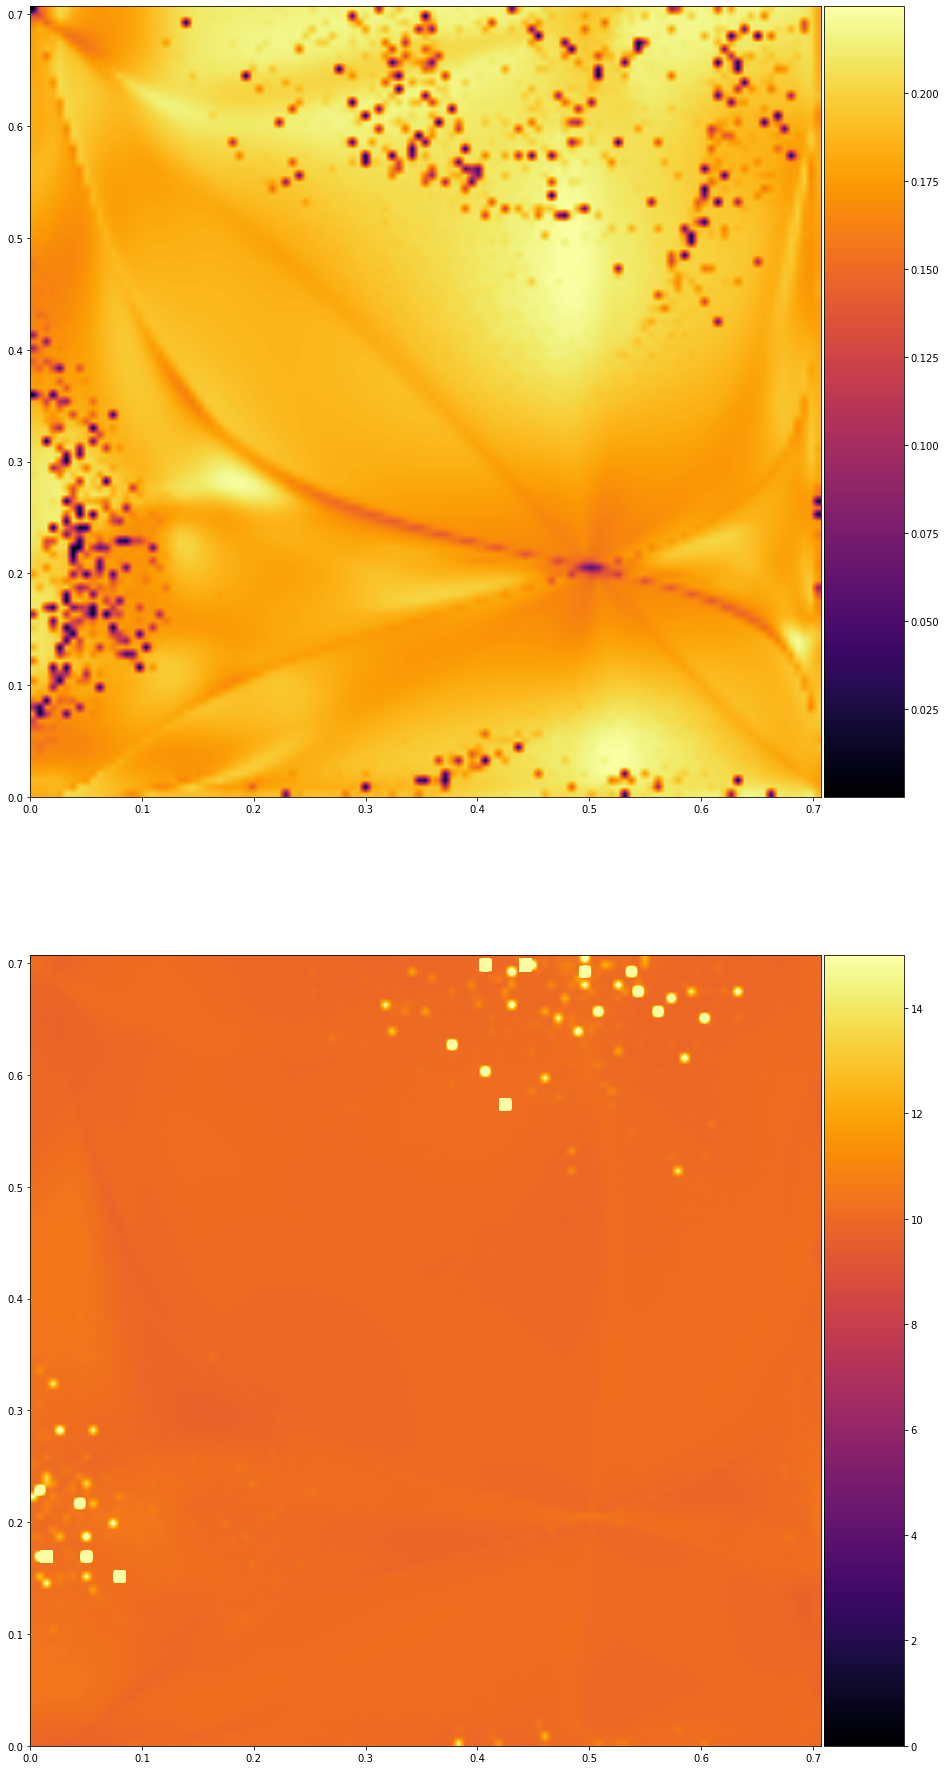

In [8]:
memory_acc_arr = mm.np.load(path_EVAL +'MA_arr_' + str(N_points) + '.npy')
gen_loss_arr = mm.np.load(path_EVAL +'LA_arr_' + str(N_points) + '.npy')



ma =  memory_acc_arr[:-1,:-1]
la = gen_loss_arr[:-1, :-1]


fig, (ax1,ax2)  = plt.subplots(nrows = 2,figsize = (32,32))
cmap = plt.get_cmap('inferno')

ma_plot = ax1.imshow(ma, cmap = cmap, interpolation  = 'bilinear', extent = [b.min(),b.max(),c.min(),c.max()], vmax=ma.max(), vmin=ma.min())
la_plot = ax2.imshow(la, cmap = cmap, interpolation  = 'bilinear',extent = [b.min(),b.max(),c.min(),c.max()], vmax=0, vmin= 15)

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size="10%", pad=0.05)

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size="10%", pad=0.05)

cbar1 = plt.colorbar(ma_plot, cax=cax1)
cbar2 = plt.colorbar(la_plot, cax=cax2)
fig.savefig(path_PRODUCT + 'MAO_PT' + '.svg', format='svg', dpi=300)


In [ ]:
# # ALTERNATIVE CONT. PLOT
# fig, (ax1,ax2) = plt.subplots(nrows = 2,figsize = (10,10))
# cmap = plt.get_cmap('inferno')

# ma =  memory_acc_arr
# la = gen_loss_arr

# levels_ma = MaxNLocator(nbins=20).tick_values(ma.min(), ma.max())
# norm_ma = BoundaryNorm(levels_ma, ncolors=cmap.N, clip=True)

# levels_la = MaxNLocator(nbins=20).tick_values(la.min(), la.max())
# norm_la = BoundaryNorm(levels_la, ncolors=cmap.N, clip=True)


# cf_ma = ax1.contourf(b,
#                   c, ma, levels=levels_ma,cmap=cmap)
# fig.colorbar(cf_ma, ax=ax1)
# ax1.set_title('MEMORY ACC')


# cf_la = ax2.contourf(b,
#                   c, la, levels=levels_la,cmap=cmap)
# fig.colorbar(cf_la, ax=ax2)
# ax2.set_title('LOSS ACC')
# plt.show()


In [ ]:
init_state = mm.qt.tensor(*[mm.qt.rand_ket(2) for _ in range(mm.n_qubits_total)])
init_state = init_state * init_state.dag()
init_state = init_state.full()

signal = (mm.np.load(path_EVAL + "0"+'SEED_SIGNAL' + '.npy') - 0.5)/10, sep = False

In [ ]:


def learning(results,signal,offset):
    y_true = mm.np.array(signal[200-offset:2200-offset]) * 2 - 1
    X = results.reshape(-1, (mm.n_qubitsB) * multiplexing)
    X = mm.np.concatenate((X, mm.np.ones((X.shape[0], 1))), axis=1)
    W = mm.np.linalg.inv(X.T @ X + 1e-27 * mm.np.eye(X.shape[1])) @ X.T @ y_true
    return X @ W, y_true

def learning_gen(results, signal, offset):
    y_true = mm.np.array(signal[200-offset:1200-offset]) * 2 - 1
    y_test = mm.np.array(signal[1200-offset:2200-offset]) * 2 - 1
    X = results.reshape(-1, (mm.n_qubitsB) * multiplexing)
    X = mm.np.concatenate((X, mm.np.ones((X.shape[0], 1))), axis=1)
    X_train = X[:1000]
    X_test = X[1000:]
    W = mm.np.linalg.inv(X_train.T @ X_train + 1e-27 *mm.np.eye(X_train.shape[1])) @ X_train.T @ y_true
    return X_test @ W, y_test



In [ ]:
# NEW SETUP EVALUATION (AVARAGE STM 60):
b = 0.3
c = 0.6
# ent_meas_operator_list = mm.two_par_measurement_anzats(b,c, False)
# sep_meas_operator_list = mm.two_par_measurement_anzats(b,c, True)

# EVALUATION CELL:
###########################################
#num_states_samples = 1
multiplexing = 10
# SPECIFYING MEASUREMENT ANZATS:

# FUNCTION EVALUATE IMPLEMENT ANALYSIS WITH  BRIDGE SET TO ON !!!
def evaluate_bridge_new(signal, depolarization_prob=0) :
    # Initialization
    inp = signal[2000:2200]
    purity = []
#     b = 0.3 + 0.01 * signal
#     c = 0.6 + 0.1 * signal
    result = mm.np.zeros((2000, multiplexing, mm.n_qubitsB))
    state = init_state
    # PRECPROCESSING --> IT IS NECESSARY TO SATISFY ECHO STATE PROPERTY. 2000 temporal preproc. steps.
    for i in tqdm(range(2000)):
        state = mm.evolution_step(state)
        state = mm.entangled_channel_step_unitary(state, depolarization_prob ,b,c, False, signal[i])
        purity.append(mm.np.trace(state@state))
        
        # NONSELECTIVE MEAS CHANNEL
    for n in tqdm(range(len(signal[200:]))): # READOUT  - >  TEMPORAL MULTIPLEXING
        state = mm.entangled_channel_step_unitary(state, depolarization_prob ,b,c, False, signal[n])
        for m in range(multiplexing):
            state = mm.evolution_step(state)
            for site in range(mm.n_qubitsB):
                #state, outcome = mm.separated_measurement_step(state, site + mm.n_qubitsA)
                state, outcome = mm.separated_measurement_step(state, site + mm.n_qubitsA)
                result[n, m, site] = outcome

    return result, purity

In [ ]:
results, purity = evaluate_bridge_new(signal)
mm.np.save(path_EVAL + "0" + 'res_NEW_ENT' + str(0), results)
plt.plot(mm.np.real(purity))

In [ ]:
purity[-1]- 1/2**mm.n_qubits_total

In [ ]:
num_sig = 0

results_ENT =  mm.np.load(path_EVAL + str(num_sig) + 'res_NEW_ENT' + str(0) + '.npy')
signal =  mm.np.load(path_EVAL + str(num_sig) + 'SEED_SIGNAL'  + '.npy')


# LEARNING EVALUATION
# UPLOAD -- ENTANGLED
res_ENT, y_true = learning(results_ENT,signal, 0)

font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=10)
font1 = {'family': 'Times New Roman',
        'weight': 'normal',
        'size': 50,
        }
# LEARNING PLOT -- ENTANGLED
fig_ENT = plt.figure(figsize = (32, 16))
ax_ENT = plt.subplot(111)
ax_ENT.tick_params(axis='both', which='major', labelsize=40, width = 3, length = 10, direction = 'inout')
ax_ENT.set_ylim(-1.5, 1.7)
plt.plot(y_true, label = 'Target', linewidth=5, linestyle = '--', color = '#005394')
plt.plot(res_ENT, label = 'Learning',linewidth=4, color = '#C54C36')
leg = plt.legend(frameon=False, loc=(0.8,0.83), prop = font1)
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
plt.setp(leg_lines, linewidth=5)
fig_ENT.savefig(path_PRODUCT + 'LEARNING_p=0_rand_sig_ENT' + '.svg', format='svg', dpi=3000)


offset = 5
# GENERALIZATION PLOT -  ENTANGLED
res_gen_ENT, y_true_gen = learning_gen(results_ENT, signal, offset)
fig_gen_ENT = plt.figure(figsize = (32, 16))
ax_gen_ENT = plt.subplot(111)
ax_gen_ENT.tick_params(axis='both', which='major', labelsize=40, width = 3, length = 10, direction = 'inout')
ax_gen_ENT.set_ylim(-1.5, 1.8)
plt.plot(y_true_gen, label = 'Target', linewidth=5, linestyle = '--', color = '#005394')
plt.plot(res_gen_ENT, label = 'Prediction',linewidth=5, color = '#C54C36')
leg = plt.legend(frameon=False, loc=(0.79,0.83), prop = font1)
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
plt.setp(leg_lines, linewidth=5)
fig_gen_ENT.savefig(path_PRODUCT + 'GEN_p=0_rand_sig_ENT' + '.svg', format='svg', dpi=3000)

In [ ]:
sig_av_macc = []
sig_av_mcap = []
sig_av_gen_loss = []

num_signal_samples = 1
for s in range(num_signal_samples):
    signal =  mm.np.load(path_EVAL + str(s) + 'SEED_SIGNAL'  + '.npy')
    results = mm.np.load(path_EVAL + str(s) + 'res_NEW_ENT' + str(0) + '.npy')
    memory_acc = get_memory_acc(results, signal)
    memory_cap = mm.np.array([mm.np.sum(memory_acc[0: d]) for d in range(1, len(memory_acc))])
    learning_acc = learn_acc(100,results, signal)
    
    sig_av_macc.append(memory_acc)
    sig_av_mcap.append(memory_cap)
    sig_av_gen_loss.append(learning_acc)
    
    
sig_av_macc = mm.np.mean(mm.np.asarray(sig_av_macc), axis = 0)
sig_av_mcap  = mm.np.mean(mm.np.asarray(sig_av_mcap), axis = 0)
sig_av_gen_loss = mm.np.mean(mm.np.asarray(sig_av_gen_loss), axis = 0)


In [ ]:
fig3, ax3 = plt.subplots(3, figsize = (16,32))
#fig = plt.figure(figsize = (32, 16))
font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=25)
font1 = {'family': 'Times New Roman',
        'weight': 'normal',
        'size': 30,
        }

ax3[0].tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10, direction = 'inout')
ax3[1].tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10, direction = 'inout')
ax3[2].tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10, direction = 'inout')

ax3[0].plot(sig_av_macc, label = 'Entangled basis', linewidth = 5, color = '#005394')
#ax3[0].plot(sig_av_macc_SEP, label = 'Separable basis', linewidth = 5,  color = '#C54C36')
ax3[0].legend(loc = 'best', prop = font1, frameon = False)

ax3[1].plot(sig_av_mcap , label = 'Entangled basis', linewidth = 5, color = '#005394')
#ax3[1].plot(sig_av_mcap_SEP, label = 'Separable basis', linewidth = 5,  color = '#C54C36')
ax3[1].legend(loc = 'best',  prop = font1, frameon = False)

ax3[2].plot(sig_av_gen_loss, label = 'Entangled basis', linewidth = 3, color = '#005394')
#ax3[2].plot(sig_av_gen_loss_SEP, label = 'Separable basis', linewidth = 3, color = '#C54C36')
ax3[2].legend(loc = 'best',  prop = font1, frameon = False)

fig3.savefig(path_PRODUCT + 'TASKS_BENCHMARKS' + '.svg', format='svg', dpi=300)